#Text Classification With Flair

##Reliability Classification

In [ ]:
import pandas as pd
Ann_full= pd.read_csv('trainDF_more2.csv',header=0)

Ann_full.drop_duplicates(subset ="text2",keep = False, inplace = True)
Ann_full

,text,label,sample_annotated,labelnew,scory,text2
2,Put it towards my heart transplant so I can see my kids grow older,FAKE,[FAKE (1.0)],FAKE,0.999998,Put it towards my heart transplant so I can see my kids grow older
4,"I havent had a transplant yet. Just waiting, 5 years and counting, but thankfully I am stable. My fir",FAKE,[FAKE (1.0)],FAKE,0.999994,"I havent had a transplant yet. Just waiting, 5 years and counting, but thankfully I am stable. My fir"
5,"""I have to say it was the right thing to go through with Henry's open heart surgery because even"" Steven Crosio",FAKE,[FAKE (1.0)],FAKE,0.999999,"""I have to say it was the right thing to go through with Henry's open heart surgery because even"" Steven Crosio"
6,All those turncoats? Did they have heart transplant? (Hriday Parivartan),FAKE,[FAKE (1.0)],FAKE,0.999999,All those turncoats? Did they have heart transplant? (Hriday Parivartan)
7,"In a 70-page document, the panel stated that Maradona, who succumbed to a heart attack on November 25 at the age of",FAKE,[TRUE (1.0)],TRUE,1.000000,"In a 70-page document, the panel stated that Maradona, who succumbed to a heart attack on November 25 at the age of"
...,...,...,...,...,...,...
19113,"take your prescribed medicines every day, even when you’re feeling great",TRUE,[TRUE (1.0)],TRUE,0.999995,"take your prescribed medicines every day, even when you’re feeling great"
19114,you should keep your blood pressure under control – that is less than 130/80 mmHg,TRUE,[TRUE (1.0)],TRUE,0.999976,you should keep your blood pressure under control – that is less than 130/80 mmHg
19115,effects of alcohol consumption on heart health are variable,TRUE,[TRUE (1.0)],TRUE,0.999959,effects of alcohol consumption on heart health are variable
19116,littlee alcohol drinking reduces your risk of having a heart attack by about 25 percent,TRUE,[TRUE (1.0)],TRUE,0.999997,littlee alcohol drinking reduces your risk of having a heart attack by about 25 percent


In [ ]:
Ann_full['labelnew'].value_counts()

TRUE    13975
FAKE     4729
Name: labelnew, dtype: int64

In [ ]:
count_class_0, count_class_1 = Ann_full.labelnew.value_counts()
count_class_1

4729

In [ ]:
df_class_0 = Ann_full[Ann_full['labelnew'] == 'TRUE']
df_class_0

Random under-sampling:
FAKE    4729
TRUE    4729
Name: labelnew, dtype: int64


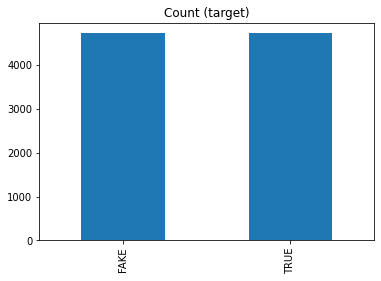

In [ ]:
# Class count
count_class_0, count_class_1 = Ann_full.labelnew.value_counts()

# Divide by class
df_class_0 = Ann_full[Ann_full['labelnew'] == 'TRUE']
df_class_1 = Ann_full[Ann_full['labelnew'] == 'FAKE']

df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.labelnew.value_counts())

df_test_under.labelnew.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
from sklearn import model_selection
train_x,test_x,train_y,test_y = model_selection.train_test_split(df_test_under,df_test_under,test_size=0.15,random_state=11)

train_x.reset_index(drop=True,inplace=True)
test_x.reset_index(drop=True,inplace=True)
train_x.shape

(8039, 6)

In [ ]:
train_x

In [ ]:
from flair.data import Corpus
from flair.datasets import SentenceDataset
from flair.data import Sentence

train_labeled=[]
for i in range(len(train_x['text2'])):
    sentence = Sentence(train_x['text2'][i]).add_label('reliability', train_x['labelnew'][i])
    train_labeled.append(sentence)

test_labeled=[]
for i in range(len(test_x['text2'])):
    sentence = Sentence(test_x['text2'][i]).add_label('reliability', test_x['labelnew'][i])
    test_labeled.append(sentence)


train = SentenceDataset(train_labeled)
test = SentenceDataset(test_labeled)

# make a corpus with train and test split
corpus = Corpus(train=train, test=test)

print(len(corpus.test))

1419


In [ ]:
print(len(corpus.test))
print(len(corpus.train))

print(len(test_labeled))
print(len(train_labeled))

1419
7235
1419
8039


In [ ]:
corpus.train[0]

Sentence: "Forty-eight ( 14 %) subjects were identified as ideal risk , 130 ( 38 %) as low risk , and 168 ( 49 %) as moderate / high risk ."   [− Tokens: 30  − Sentence-Labels: {'reliability': [TRUE (1.0)]}]

https://huggingface.co/monologg/biobert_v1.1_pubmed

https://huggingface.co/dmis-lab/biobert-v1.1

In [ ]:
from flair.data import Corpus
#from flair.datasets import TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer

In [ ]:
from torch.optim.adam import Adam

from flair.data import Corpus
#from flair.datasets import TREC_6
from flair.embeddings import TransformerDocumentEmbeddings
from flair.embeddings import TransformerWordEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer

# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()

document_embeddings = TransformerDocumentEmbeddings('dmis-lab/biobert-v1.1', fine_tune=True)

# 4. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 5. initialize the text classifier trainer with Adam optimizer
trainer = ModelTrainer(classifier, corpus, optimizer=Adam)

# 6. start the training
trainer.train('result/misinformation3/',
              learning_rate=3e-5, # use very small learning rate
              mini_batch_size=32,
              mini_batch_chunk_size=4, # optionally set this if transformer is too much for your machine
              max_epochs=5, # terminate after 5 epochs
              )

2021-07-06 20:49:24,168 Computing label dictionary. Progress:


100%|██████████| 8654/8654 [00:00<00:00, 51239.80it/s]

2021-07-06 20:49:24,343 [b'TRUE', b'FAKE']


2021-07-06 20:49:28,986 ----------------------------------------------------------------------------------------------------
2021-07-06 20:49:28,989 Model: "TextClassifier(
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
               

{'dev_loss_history': [0.09946069121360779,
  0.13370302319526672,
  0.1329623907804489,
  0.21395991742610931,
  0.21572962403297424],
 'dev_score_history': [0.9689, 0.9664, 0.9726, 0.9677, 0.9714],
 'test_score': 0.9796,
 'train_loss_history': [0.10224316799954848,
  0.02695970654047671,
  0.019928589739106703,
  0.0017740810055980668,
  0.001015372949048831]}

##Category Classification

**Build the corpus**

In [ ]:
from sklearn import model_selection
train_x,test_x,train_y,test_y = model_selection.train_test_split(result_all,result_all,test_size=0.20,random_state=11)

train_x.reset_index(drop=True,inplace=True)
test_x.reset_index(drop=True,inplace=True)
train_x.shape

(13790, 5)

In [ ]:
from flair.data import Corpus
from flair.datasets import SentenceDataset
from flair.data import Sentence

train_labeled=[]
for i in range(len(train_x['text2'])):
    sentence = Sentence(train_x['text2'][i]).add_label('type', train_x['source'][i]) #-->change label to source if you want all labels
    train_labeled.append(sentence)

test_labeled=[]
for i in range(len(test_x['text2'])):
    sentence = Sentence(test_x['text2'][i]).add_label('type', test_x['source'][i]) #-->change label to source if you want all labels
    test_labeled.append(sentence)


train = SentenceDataset(train_labeled)
test = SentenceDataset(test_labeled)

# make a corpus with train and test split
corpus = Corpus(train=train, test=test)

print(len(corpus.test))

3448


In [ ]:
print(len(corpus.test))
print(len(corpus.train))

print(len(test_labeled))
print(len(train_labeled))

3448
12411
3448
13790


In [ ]:
corpus.train[0]

Sentence: "To mark the 1 year anniversary of her life-saving heart transplant , Hayley is taking to the skydives and jumping 13"   [− Tokens: 21  − Sentence-Labels: {'type': [Heart transplant (1.0)]}]

In [ ]:
from flair.data import Corpus
#from flair.datasets import TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer

In [ ]:
# 1. get the corpus -->already loaded
#corpus: Corpus = TREC_6()

# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()

# 3. make a list of word embeddings
word_embeddings = [WordEmbeddings('pubmed')]

# 4. initialize document embedding by passing list of word embeddings
# Can choose between many RNN types (GRU by default, to change use rnn_type parameter)
document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=256)

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus)

# 7. start the training
trainer.train('result2/type_disease_trans_more2',
              learning_rate=0.1,
              mini_batch_size=32,
              anneal_factor=0.5,
              patience=5,
              max_epochs=150)

2021-07-01 23:53:13,407 Computing label dictionary. Progress:


100%|██████████| 14796/14796 [00:00<00:00, 37691.35it/s]

2021-07-01 23:53:13,805 [b'heart disease treatment', b'heart attack symptoms', b'Coronary artery disease treatment', b'Coronary artery disease', b'heart disease causes', b'heart disease symptoms', b'heart disease', b'heart attack', b'Coronary artery disease symptoms', b'heart attack causes', b'heart attack treatment']


2021-07-01 23:53:41,566 ----------------------------------------------------------------------------------------------------
2021-07-01 23:53:41,568 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('pubmed')
    )
    (word_reprojection_map): Linear(in_features=200, out_features=200, bias=True)
    (rnn): GRU(200, 256, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Linear(in_features=256, out_features=11, bias=True)
  (loss_function): CrossEntropyLoss()
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)"
2021-07-01 23:53:41,569 ----------------------------------------------------------------------------------------------------
2021-07-01 23:53:41,570 Corpus: "Corpus: 11579 train + 1287 dev + 3217 test sentences"
2021-07-01 23:53:41,571 ----------------------------------------------------------------------------------------------------
2021-07-01 23

{'dev_loss_history': [1.9398726224899292,
  1.746006965637207,
  1.6646513938903809,
  2.0038962364196777,
  1.5489041805267334,
  1.483956217765808,
  1.4494092464447021,
  1.348284125328064,
  1.355925440788269,
  1.298179030418396,
  1.246789813041687,
  1.253495454788208,
  1.2359247207641602,
  1.1955465078353882,
  1.2415273189544678,
  1.1884955167770386,
  1.1972590684890747,
  1.2240028381347656,
  1.2093459367752075,
  1.1689499616622925,
  1.197001576423645,
  1.167676329612732,
  1.1566675901412964,
  1.1460100412368774,
  1.1691254377365112,
  1.1636170148849487,
  1.1686890125274658,
  1.1462483406066895,
  1.16313636302948,
  1.1826997995376587,
  1.147223711013794,
  1.1191024780273438,
  1.1130013465881348,
  1.1397002935409546,
  1.1224716901779175,
  1.1221801042556763,
  1.1188210248947144,
  1.1723276376724243,
  1.141560673713684,
  1.1323083639144897,
  1.1455167531967163,
  1.1808514595031738,
  1.1256544589996338,
  1.1510930061340332,
  1.1402772665023804,
  1

In [ ]:
from flair.data import Corpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer

In [ ]:
from torch.optim.adam import Adam

from flair.data import Corpus
#from flair.datasets import TREC_6
from flair.embeddings import TransformerDocumentEmbeddings
from flair.embeddings import TransformerWordEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer

# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()
#word_embeddings = [TransformerWordEmbeddings('monologg/biobert_v1.1_pubmed')]
# 3. initialize transformer document embeddings (many models are available)
document_embeddings = TransformerDocumentEmbeddings('dmis-lab/biobert-v1.1', fine_tune=True)

# 4. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 5. initialize the text classifier trainer with Adam optimizer
trainer = ModelTrainer(classifier, corpus, optimizer=Adam)

# 6. start the training
trainer.train('result/type_disease_trans_more',
              learning_rate=3e-5, # use very small learning rate
              mini_batch_size=32,
              mini_batch_chunk_size=4, # optionally set this if transformer is too much for your machine
              max_epochs=5, # terminate after 5 epochs
              )

2021-07-01 23:20:40,025 Computing label dictionary. Progress:


100%|██████████| 14796/14796 [00:00<00:00, 42195.34it/s]

2021-07-01 23:20:40,382 [b'heart disease treatment', b'heart attack symptoms', b'Coronary artery disease treatment', b'Coronary artery disease', b'heart disease causes', b'heart disease symptoms', b'heart disease', b'heart attack', b'Coronary artery disease symptoms', b'heart attack causes', b'heart attack treatment']


2021-07-01 23:20:50,067 ----------------------------------------------------------------------------------------------------
2021-07-01 23:20:50,069 Model: "TextClassifier(
  (document_embeddings): TransformerDocumentEmbeddings(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
               

{'dev_loss_history': [1.0175752639770508,
  0.9552109241485596,
  1.0968012809753418,
  1.1822303533554077,
  1.5024904012680054],
 'dev_score_history': [0.6612, 0.7016, 0.6946, 0.7148, 0.7032],
 'test_score': 0.709,
 'train_loss_history': [1.2477397737787903,
  0.7578434164234493,
  0.3787053029010463,
  0.1758029050638646,
  0.09723164076747717]}